In [1]:
import numpy as np

#Define network

이전 주차의 TwoLayerNet에서 레이어 수, 가중치 초기화 및 감소, dropout, batchnorm 기능을 추가하였습니다.

**self.__init_weight()**과 **self.loss()**의 빈칸을 채워주세요!

In [47]:
from collections import OrderedDict

class MultiLayerNet:
    '''
    input_size: 입력 크기 (MNIST의 경우 784)
    hidden_size_list: 은닉층 뉴런 개수의 리스트 (예: [100,100,100])
    output_size: 출력 크기 (MNIST의 경우 10)
    activation: 'relu' 또는 'sigmoid'
    weight_init_std: 가중치의 표준 편차 지정 (예: 0.01)
    'relu' 또는 'he'를 지정하면 He 초기화를 설정
    'sigmoid' 또는 'xavier'를 지정하면 Xavier 초기화를 설정
    weight_decay_lambda: Weight Decay(L2 정규화)의 강도
    use_dropout: Dropout을 사용할지 여부
    dropout_ration: Dropout 비율
    use_batchNorm: Batch Normalization을 사용할지 여부
    '''

    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ratio = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        self.__init_weight(weight_init_std)

        # 레이어 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()


    def __init_weight(self, weight_init_std):
        """가중치 초기값 설정
        weight_init_std : 가중치의 표준 편차 지정 (예: 0.01)
        'relu' 또는 'he'를 지정하면 "He 초기화"를 설정
        'sigmoid' 또는 'xavier'를 지정하면 "Xavier 초기화"를 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx-1])  # ReLU
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx-1]) # sigmoid
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])


    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x


    def loss(self, x, t, train_flg=False):
        """손실 함수 정의
        입력 값 x는 입력 데이터, t는 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay


    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        # 원핫인코딩이면 실제 라벨로 반환
        accuracy = np.sum(y == t) / float(x.shape[0])
        # 전체 샌플 수 대비 맞춘 샘플 수 계산
        return accuracy


    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)


        grads = {}
        for idx in range(1, self.hidden_layer_num+2): #출력층도 포함해야해서 +2
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1: # 출력층에는 batchnorm 적용 안함
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

#Layers

각 레이어에는 init, forward, backward 함수가 정의되어 있습니다.

sigmoid 계층이 추가되었습니다.

In [20]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b

        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx

In [22]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [23]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

In [25]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        # 원핫벡터
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        # 정수 인덱스
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            # 젤 높은 확률 1 빼주기 y-t와 같은 결과
            dx = dx / batch_size

        return dx

#Functions

복습차원에서 빈칸을 채워봅시다!

In [26]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [27]:
def cross_entropy_error(y, t):
    # 1차원이면 2차원 변환
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # one-hot이면 인덱스 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
                        # 각 샘플에 대해 정답 클래스 확률만 추출

#Optimizers

파라미터와 기울기를 인수로 받아서 파라미터를 갱신합니다.

Adam optimizer가 추가되었습니다.

In [28]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [29]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [30]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [32]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1  # momentum
        self.beta2 = beta2  # adagrad
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        # 시간에 따른 학습률 변화
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)


        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

# Regularization

**BatchNormalization**

배치 단위로 정규화하고, 감마와 베타의 기울기를 구하는 과정을 살펴보세요.

계산 그래프에서 dx가 전달되는 과정을 알게 쉽게 설명한 글입니다!

https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

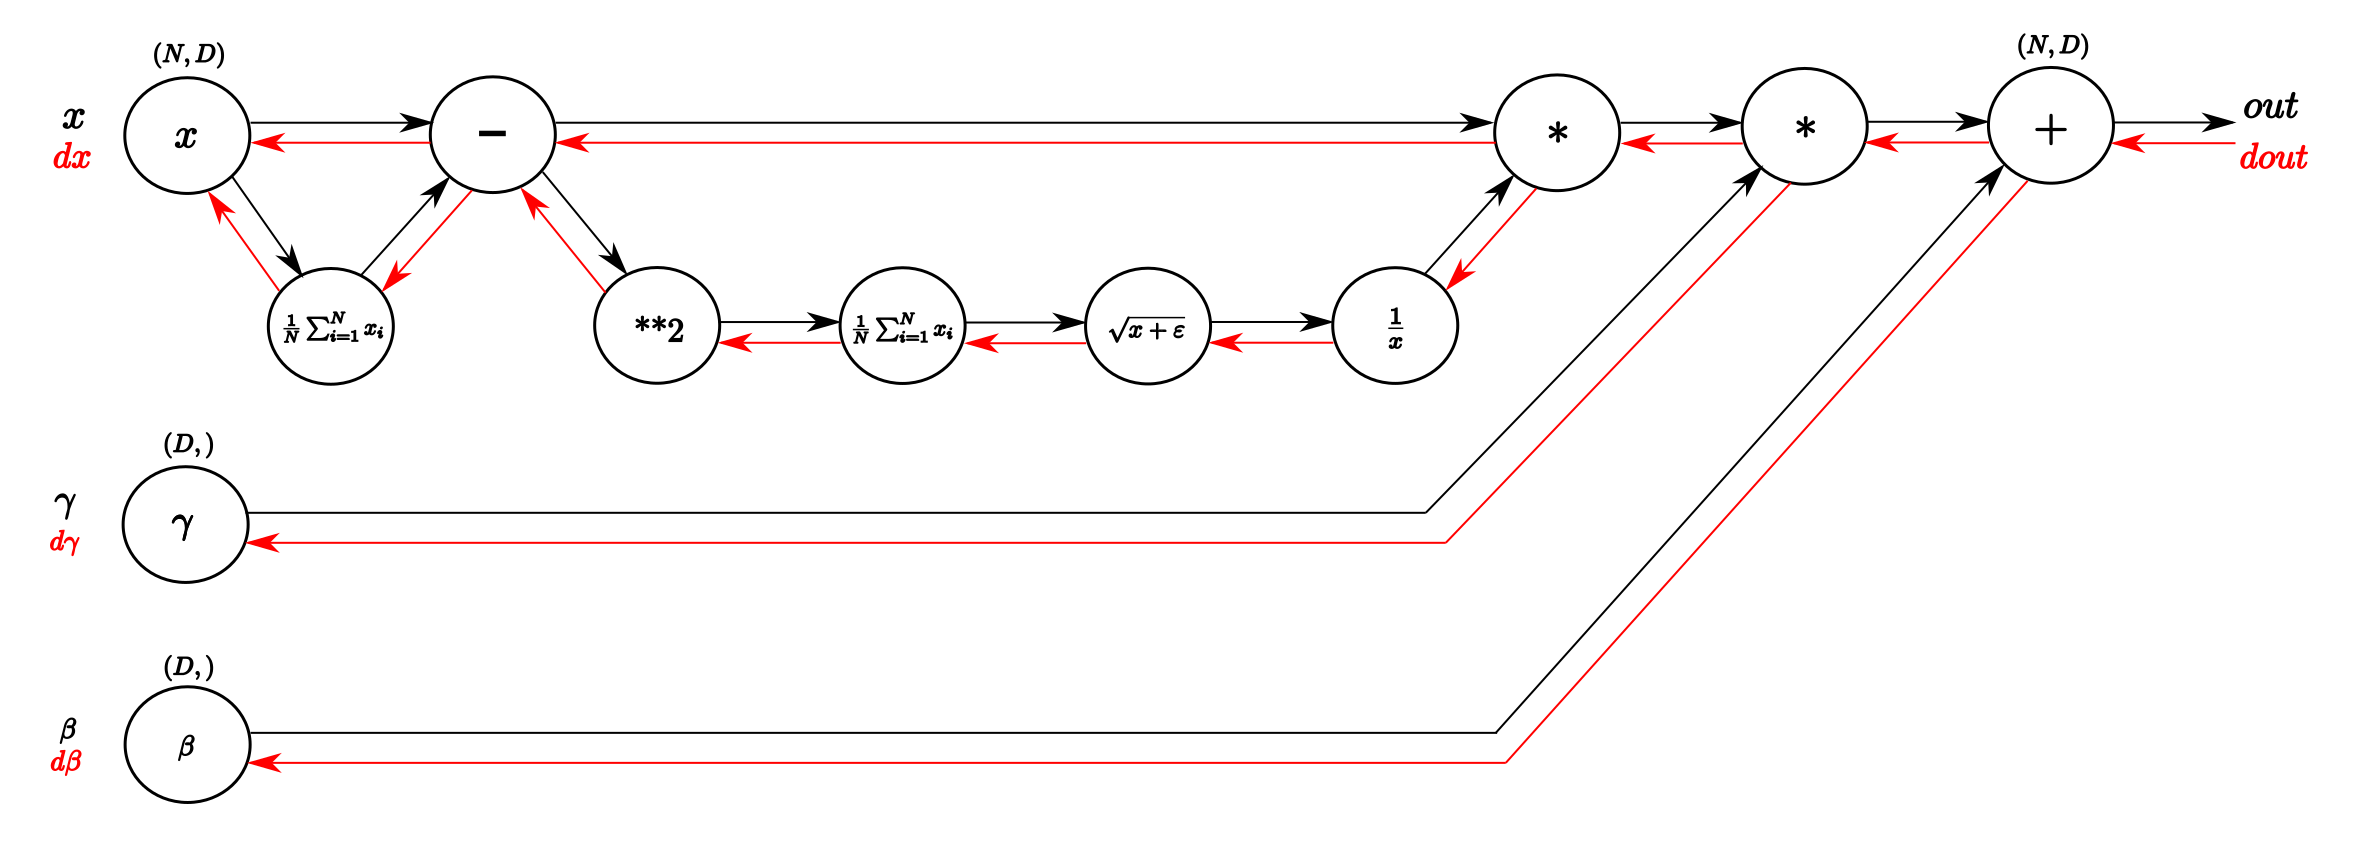

In [48]:
class BatchNormalization:
  """
  http://arxiv.org/abs/1502.03167
  """
  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
      self.gamma = gamma
      self.beta = beta
      self.momentum = momentum
      self.input_shape = None # Conv 층=4차원, 완전 연결층=2차원

      # 테스트 시 사용하는 평균과 분산(즉, 업데이트 대상)
      self.running_mean = running_mean
      self.running_var = running_var

      # backward 시에 사용하는 중간 데이터
      self.batch_size = None
      self.xc = None
      self.std = None
      self.dgamma = None
      self.dbeta = None

  def forward(self, x, train_flg=True):
      self.input_shape = x.shape
      if x.ndim != 2: # 2차원이 아닌겨우 ex)cnn
          N, C, H, W = x.shape
          x = x.reshape(N, -1)

      out = self.__forward(x, train_flg)

      return out.reshape(*self.input_shape)


  def __forward(self, x, train_flg):
      if self.running_mean is None:
          N, D = x.shape
          self.running_mean = np.zeros(D)
          self.running_var = np.zeros(D)

      if train_flg: # train
          mu = x.mean(axis=0)
          xc = x - mu
          var = np.mean(xc**2, axis=0)
          std = np.sqrt(var + 10e-7)
          xn = xc / std
          
          # backward 위해 저장
          self.batch_size = x.shape[0]
          self.xc = xc
          self.xn = xn
          self.std = std
          # 평균과 분산의 이동 평균 계산 (backward)
          self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
          self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
      else: # test
          # 추론 과정
          xc = x - self.running_mean
          xn = xc / ((np.sqrt(self.running_var+ 10e-7)))

      out = self.gamma * xn + self.beta
      return out


  def backward(self, dout):
      if dout.ndim != 2:
          N, C, H, W = dout.shape
          dout = dout.reshape(N, -1)

      dx = self.__backward(dout)

      dx = dx.reshape(*self.input_shape)
      return dx


  def __backward(self, dout):
      dbeta = dout.sum(axis=0) # shift parameter ->전체 gradient 더하면 됨
      dgamma = np.sum(self.xn * dout, axis=0) # scale parameter 
      dxn = self.gamma * dout #out = γ * xn + β
      dxc = dxn / self.std # xn=xc/std
      dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0) # xn에서 끊어서 chainrule
      dvar = 0.5 * dstd / self.std
      dxc += (2.0 / self.batch_size) * self.xc * dvar
      dmu = np.sum(dxc, axis=0)
      dx = dxc - dmu / self.batch_size

      self.dgamma = dgamma
      self.dbeta = dbeta

      return dx

**Dropout**

In [50]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg: # train
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            # 0~1사이 랜덤 생성 후 dropout_ratio 보다 큰 값 True 작으면 False
            return x * self.mask
        else: # test
            return x * (1.0-self.dropout_ratio) # 테스트 시에는 뉴런 드롭 못함, 스케일 보정
    def backward(self, dout):
        return dout * self.mask # 드롭 아웃된 뉴런에는 gradient 전달 안되어야하므로, selfmask 그대로 사용

# Training

In [16]:
from torchvision import datasets, transforms

cifar10_train = datasets.MNIST(root='./data', train=True, download=True)
cifar10_test = datasets.MNIST(root='./data', train=False, download=True)

# flatten, normalization
x_train = cifar10_train.data.numpy().reshape(-1, 28 * 28).astype('float32') / 255.0
t_train = cifar10_train.targets
x_test = cifar10_test.data.numpy().reshape(-1, 28 * 28).astype('float32') / 255.0
t_test = cifar10_test.targets

# y one-hot encodeing
n = len(np.unique(t_train))
t_train = np.eye(n)[t_train]
t_test = np.eye(n)[t_test]

print(f'x_train.shape: {x_train.shape}')
print(f't_train.shape: {t_train.shape}')

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

x_train.shape: (60000, 784)
t_train.shape: (60000, 10)


정규화 기법을 하나씩 적용해보고, 그렇지 않은 경우의 결과를 비교해보세요!

epoch:0, train acc:0.09, test acc:0.089
epoch:1, train acc:0.1, test acc:0.0932
epoch:2, train acc:0.13, test acc:0.1031
epoch:3, train acc:0.17, test acc:0.1108
epoch:4, train acc:0.18666666666666668, test acc:0.1244
epoch:5, train acc:0.2, test acc:0.1468
epoch:6, train acc:0.21666666666666667, test acc:0.1604
epoch:7, train acc:0.24666666666666667, test acc:0.1823
epoch:8, train acc:0.27, test acc:0.2053
epoch:9, train acc:0.32666666666666666, test acc:0.2389
epoch:10, train acc:0.38333333333333336, test acc:0.2733
epoch:11, train acc:0.44, test acc:0.3016
epoch:12, train acc:0.47, test acc:0.3245
epoch:13, train acc:0.5133333333333333, test acc:0.3486
epoch:14, train acc:0.53, test acc:0.3633
epoch:15, train acc:0.5533333333333333, test acc:0.3809
epoch:16, train acc:0.5933333333333334, test acc:0.4025
epoch:17, train acc:0.6266666666666667, test acc:0.4197
epoch:18, train acc:0.6066666666666667, test acc:0.4169
epoch:19, train acc:0.63, test acc:0.4461
epoch:20, train acc:0.62, te

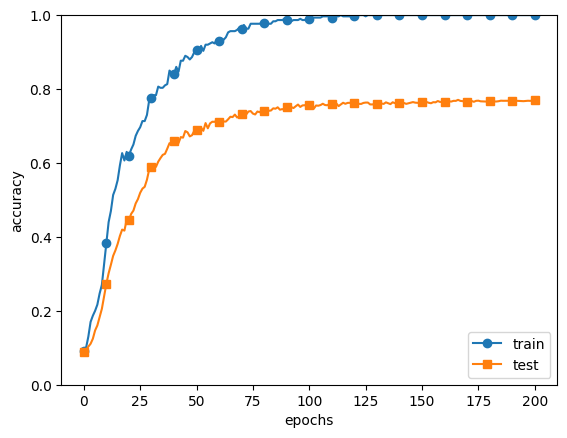

In [35]:
import matplotlib.pyplot as plt


x_train = x_train[:300]   # 적은 데이터를 가정
t_train = t_train[:300]

# 1. 정규화 적용하지않은 기본모델
# 2. 가중치 감쇠 weight_decay_lambda=0.1
# 3. 드롭아웃만 적용 use_dropout=True, dropout_ratio=0.5
# 4. 배치 정규화만 적용 use_batchnorm=True
# 5. 정규화 모두 적용
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=0,use_dropout=False, use_batchnorm=False)


optimizer = SGD(lr=0.01) 
# optimizer = Adam(lr=0.01, beta1=0.9, beta2=0.999)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):   # 과적합 유도
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

▶ 실행 시작: norm = none, optimizer = sgd
epoch 0: train acc = 0.0900, test acc = 0.1024
epoch 1: train acc = 0.0900, test acc = 0.1067
epoch 2: train acc = 0.1067, test acc = 0.1129
epoch 3: train acc = 0.1100, test acc = 0.1196
epoch 4: train acc = 0.1133, test acc = 0.1220
epoch 5: train acc = 0.1367, test acc = 0.1305
epoch 6: train acc = 0.1633, test acc = 0.1356
epoch 7: train acc = 0.1800, test acc = 0.1428
epoch 8: train acc = 0.2300, test acc = 0.1661
epoch 9: train acc = 0.2900, test acc = 0.1830
epoch 10: train acc = 0.3267, test acc = 0.2078
epoch 11: train acc = 0.3567, test acc = 0.2342
epoch 12: train acc = 0.4167, test acc = 0.2581
epoch 13: train acc = 0.4433, test acc = 0.2832
epoch 14: train acc = 0.4667, test acc = 0.3065
epoch 15: train acc = 0.4733, test acc = 0.3185
epoch 16: train acc = 0.4933, test acc = 0.3373
epoch 17: train acc = 0.5267, test acc = 0.3481
epoch 18: train acc = 0.5367, test acc = 0.3684
epoch 19: train acc = 0.5600, test acc = 0.3711
epoch 20: tr

C:\Users\eunse\AppData\Local\Temp\ipykernel_9544\1756018775.py:93: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
C:\Users\eunse\AppData\Local\Temp\ipykernel_9544\1756018775.py:93: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
C:\Users\eunse\AppData\Local\Temp\ipykernel_9544\1756018775.py:93: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
C:\Users\eunse\AppData\Local\Temp\ipykernel_9544\1756018775.py:93: UserWarning: Glyph 50741 (\N{HANGUL SYLLABLE OB}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
C:\Users\eunse\AppData\Local\Temp\ipykernel_9544\1756018775.py:93: UserWarning: Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
C:\Users\eunse\AppData\Local\Temp\ipykernel_9544\175601

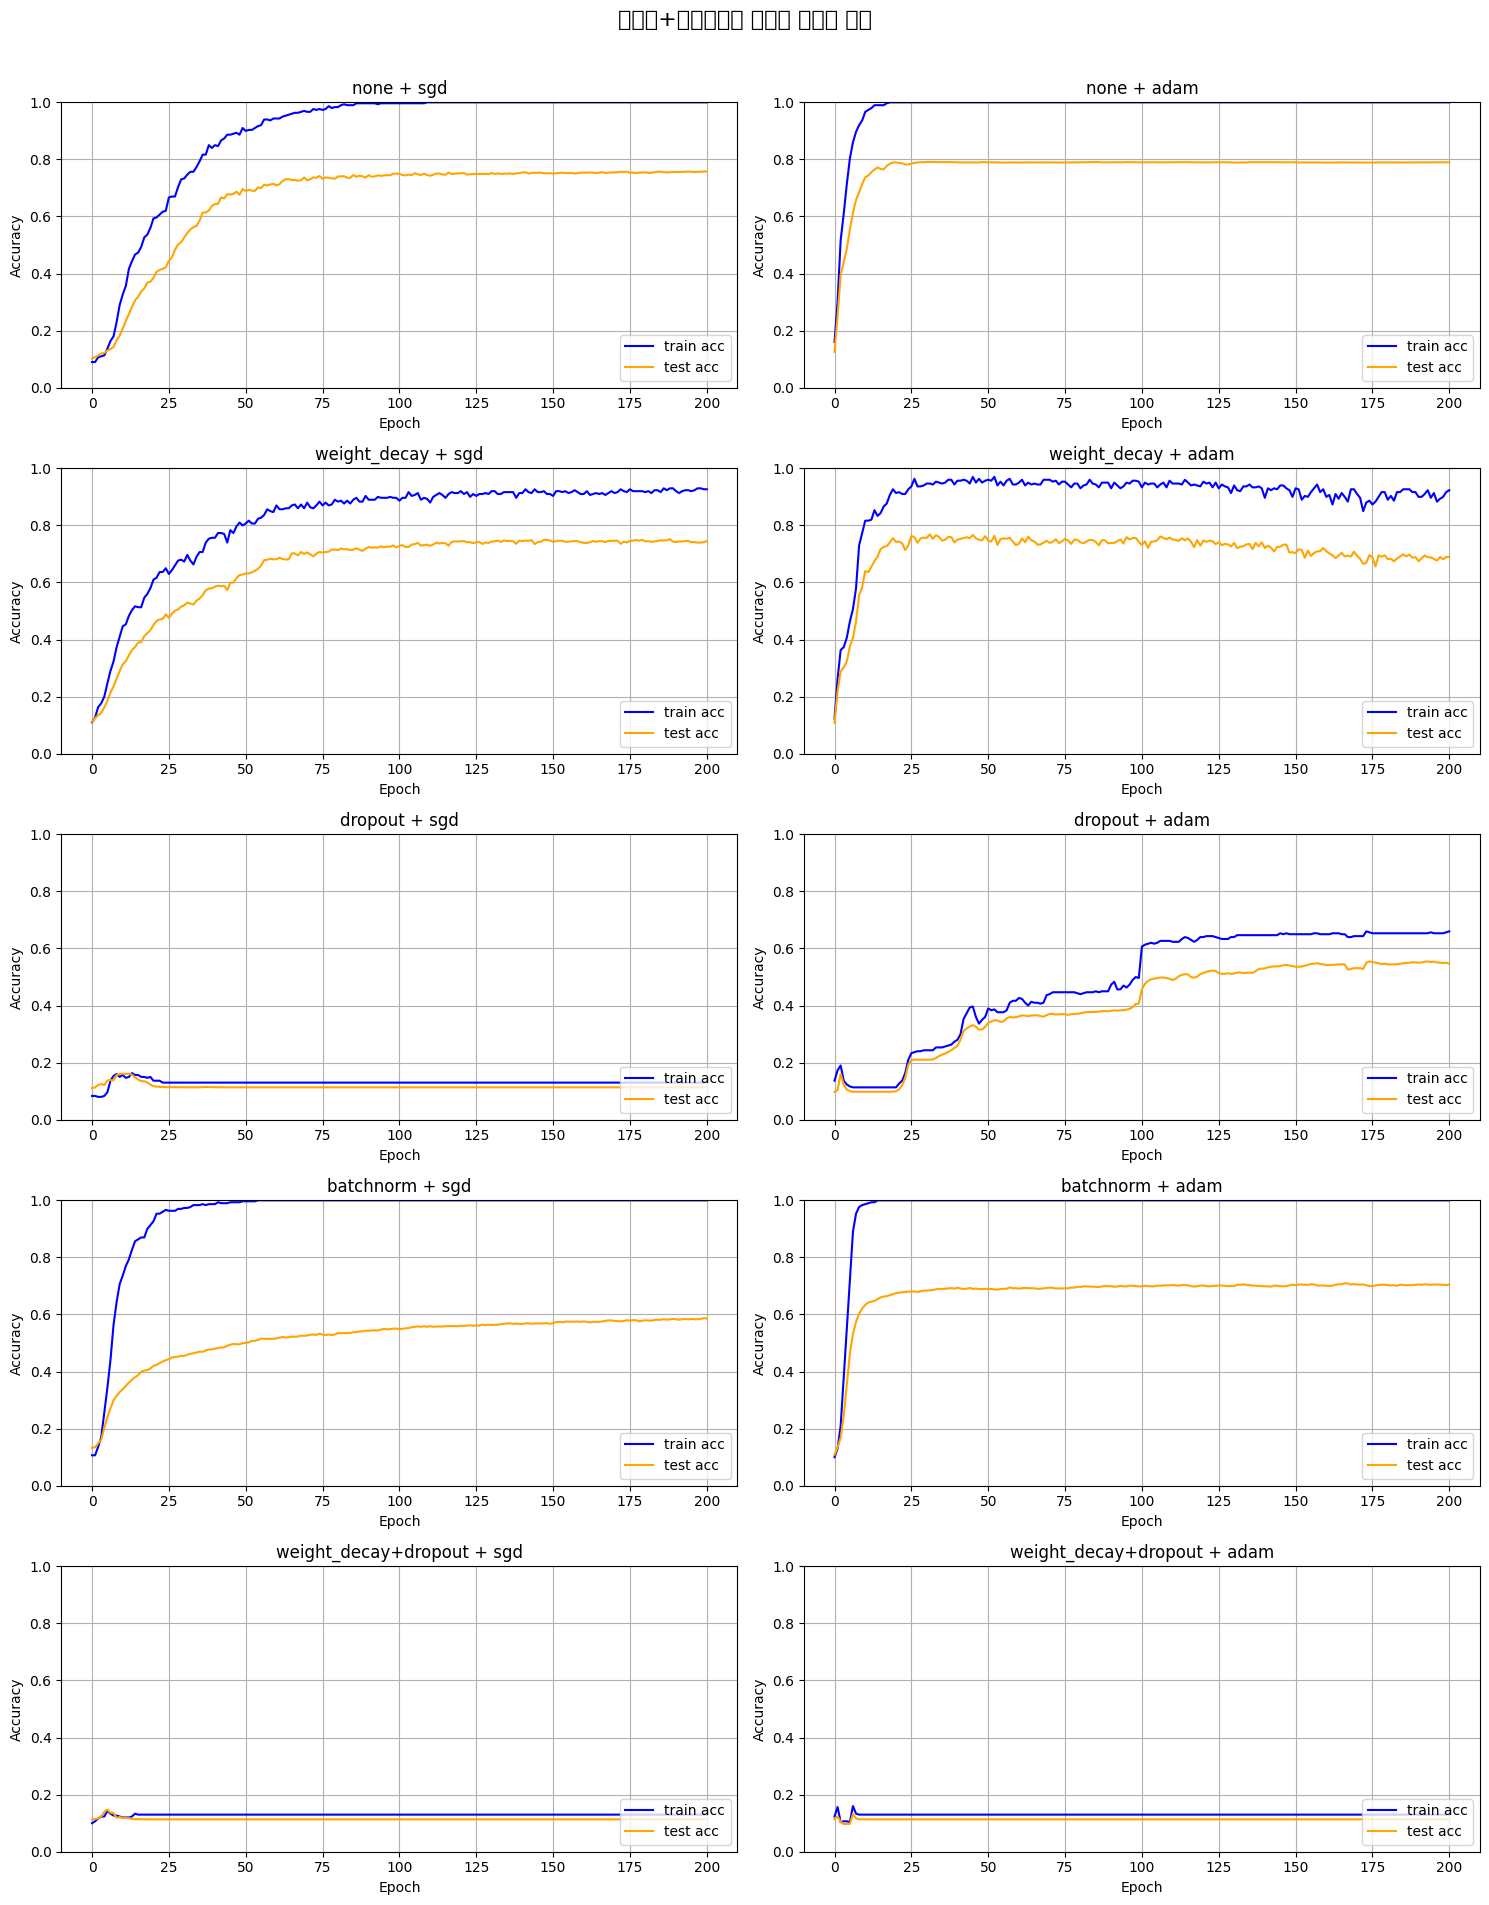

In [52]:
results = {}  # key: (정규화, 옵티마이저), value: {'train': [], 'test': []}

# 조합 정의
norm_list = ['none', 'weight_decay', 'dropout', 'batchnorm', 'weight_decay+dropout']
opt_list = ['sgd', 'adam']

for norm in norm_list:
    for opt_type in opt_list:
        print(f"▶ 실행 시작: norm = {norm}, optimizer = {opt_type}")

        # 하이퍼파라미터 설정
        weight_decay_lambda = 0.1 if 'weight_decay' in norm else 0
        use_dropout = 'dropout' in norm
        use_batchnorm = 'batchnorm' in norm

        # 모델 정의
        network = MultiLayerNet(
            input_size=784,
            hidden_size_list=[100]*6,
            output_size=10,
            weight_decay_lambda=weight_decay_lambda,
            use_dropout=use_dropout,
            dropout_ratio=0.5,
            use_batchnorm=use_batchnorm
        )

        # 옵티마이저 정의
        if opt_type == 'sgd':
            optimizer = SGD(lr=0.01)
        else:
            optimizer = Adam()

        # 학습 설정
        max_epochs = 201
        batch_size = 100
        train_size = x_train.shape[0]
        iter_per_epoch = max(train_size // batch_size, 1)

        # 결과 저장용 리스트
        train_acc_list = []
        test_acc_list = []
        epoch_cnt = 0

        for i in range(10000000):
            # 미니배치
            batch_mask = np.random.choice(train_size, batch_size)
            x_batch = x_train[batch_mask]
            t_batch = t_train[batch_mask]

            # 기울기 계산 및 갱신
            grads = network.gradient(x_batch, t_batch)
            optimizer.update(network.params, grads)

            if i % iter_per_epoch == 0:
                train_acc = network.accuracy(x_train, t_train)
                test_acc = network.accuracy(x_test, t_test)
                train_acc_list.append(train_acc)
                test_acc_list.append(test_acc)
                print(f"epoch {epoch_cnt}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")

                epoch_cnt += 1
                if epoch_cnt >= max_epochs:
                    break

        # 결과 저장
        results[(norm, opt_type)] = {
            'train': train_acc_list,
            'test': test_acc_list
        }


import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle("정규화+옵티마이저 조합별 정확도 비교", fontsize=16)

for idx, ((norm, opt), result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    x = np.arange(len(result['train']))
    ax.plot(x, result['train'], label='train acc', color='blue')
    ax.plot(x, result['test'], label='test acc', color='orange')

    ax.set_title(f"{norm} + {opt}")
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='lower right')
    ax.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()



In [ ]:
# 결과해석
Adam optimizer는 전반적으로 빠르게 수렴하지만, 정규화를 하지 않으면 test 정확도가 낮고 과적합이 쉽게 발생한다.
반면, SGD는 상대적으로 느리지만 적절한 정규화가 추가되면 test 정확도가 높아지는 경향을 보인다.
Weight Decay는 과적합을 억제하고 안정적인 일반화 성능을 만들어내며, 
Batch Normalization은 학습 속도를 빠르게 하고 train/test 성능 모두 우수하게 만든다. 
특히 batchnorm + sgd 조합은 가장 좋은 test 성능을 보인다.
결론적으로, BatchNorm과 Weight Decay는 매우 효과적인 정규화 기법이고, Dropout은 현재 상태에서는 재구현이 필요하다.